In [17]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from src.config import get_paths
from src.IO import read_parquet

paths = get_paths(project_root)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
customer_metrics = read_parquet(paths.root / "data" / "processed" / "customer_metrics.parquet")

In [20]:
customer_metrics.head()

,customer_unique_id,first_purchase_date,last_purchase_date,n_orders,total_revenue,avg_order_value,customer_state,tenure_days
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,1,141.90,141.90,SP,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,1,27.19,27.19,SP,0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,1,86.22,86.22,SC,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,1,43.62,43.62,PA,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,1,196.89,196.89,SP,0


In [21]:
customer_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94399 entries, 0 to 94398
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_unique_id   94399 non-null  object        
 1   first_purchase_date  94399 non-null  datetime64[ns]
 2   last_purchase_date   94399 non-null  datetime64[ns]
 3   n_orders             94399 non-null  int64         
 4   total_revenue        94399 non-null  float64       
 5   avg_order_value      94398 non-null  float64       
 6   customer_state       94399 non-null  object        
 7   tenure_days          94399 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 5.8+ MB


In [22]:
customer_metrics.isna().sum()

customer_unique_id     0
first_purchase_date    0
last_purchase_date     0
n_orders               0
total_revenue          0
avg_order_value        1
customer_state         0
tenure_days            0
dtype: int64

In [23]:
customer_metrics.duplicated().sum()

np.int64(0)

In [24]:
df = customer_metrics.copy()
df=df.sort_values("total_revenue", ascending=False).reset_index(drop=True)

In [25]:
df.head()

,customer_unique_id,first_purchase_date,last_purchase_date,n_orders,total_revenue,avg_order_value,customer_state,tenure_days
0,0a0a92112bd4c708ca5fde585afaa872,2017-09-29 15:24:52,2017-09-29 15:24:52,1,13664.08,13664.080,RJ,0
1,da122df9eeddfedc1dc1f5349a1a690c,2017-04-01 15:58:40,2017-04-01 15:58:41,2,7571.63,3785.815,RJ,0
2,763c8b1c9c68a0229c42c9fc6f662b93,2018-07-15 14:49:44,2018-07-15 14:49:44,1,7274.88,7274.880,ES,0
3,dc4802a71eae9be1dd28f5d788ceb526,2017-02-12 20:37:36,2017-02-12 20:37:36,1,6929.31,6929.310,MS,0
4,459bef486812aa25204be022145caa62,2018-07-25 18:10:17,2018-07-25 18:10:17,1,6922.21,6922.210,ES,0


In [26]:
total_revenue = df["total_revenue"].sum()
n_customers = df.shape[0]   
print(f"Total Revenue: {total_revenue}")
print(f"Number of Customers: {n_customers}")

Total Revenue: 15599675.73
Number of Customers: 94399


In [27]:
df['rev_share'] = df['total_revenue'] / total_revenue
df['cum_rev_share'] = df['rev_share'].cumsum()


In [28]:
df["customer_rank"] = np.arange(1, n_customers + 1)
df["cum_customer_share"] = df["customer_rank"] / n_customers

In [29]:
df.head()

,customer_unique_id,first_purchase_date,last_purchase_date,n_orders,total_revenue,avg_order_value,customer_state,tenure_days,rev_share,cum_rev_share,customer_rank,cum_customer_share
0,0a0a92112bd4c708ca5fde585afaa872,2017-09-29 15:24:52,2017-09-29 15:24:52,1,13664.08,13664.080,RJ,0,0.000876,0.000876,1,0.000011
1,da122df9eeddfedc1dc1f5349a1a690c,2017-04-01 15:58:40,2017-04-01 15:58:41,2,7571.63,3785.815,RJ,0,0.000485,0.001361,2,0.000021
2,763c8b1c9c68a0229c42c9fc6f662b93,2018-07-15 14:49:44,2018-07-15 14:49:44,1,7274.88,7274.880,ES,0,0.000466,0.001828,3,0.000032
3,dc4802a71eae9be1dd28f5d788ceb526,2017-02-12 20:37:36,2017-02-12 20:37:36,1,6929.31,6929.310,MS,0,0.000444,0.002272,4,0.000042
4,459bef486812aa25204be022145caa62,2018-07-25 18:10:17,2018-07-25 18:10:17,1,6922.21,6922.210,ES,0,0.000444,0.002716,5,0.000053


In [30]:
cutoffs = [0.01, 0.05, 0.10, 0.20]
rows = []

for c in cutoffs:
    k = int(np.ceil(c * n_customers))
    revenue_share = df.loc[:k-1, "total_revenue"].sum() / total_revenue
    rows.append({
        "top_pct_customers": c,
        "n_customers": k,
        "revenue_share": revenue_share
    })

top_share_table = pd.DataFrame(rows)
top_share_table["top_pct_customers"] = (top_share_table["top_pct_customers"] * 100).round(1).astype(str) + "%"
top_share_table["revenue_share"] = (top_share_table["revenue_share"] * 100).round(2)


In [31]:
top_share_table

,top_pct_customers,n_customers,revenue_share
0,1.0%,944,10.34
1,5.0%,4720,26.78
2,10.0%,9440,38.25
3,20.0%,18880,53.53


In [32]:
def pct_customers_to_reach(target_rev_share: float) -> float:
    idx = df["cum_rev_share"].searchsorted(target_rev_share, side="left")
    return (idx + 1) / n_customers

targets = [0.50, 0.80, 0.90]
reach_rows = []

for t in targets:
    pct = pct_customers_to_reach(t)
    reach_rows.append({
        "target_revenue_share": f"{int(t*100)}%",
        "pct_customers_needed": round(pct * 100, 2),
        "n_customers_needed": int(np.ceil(pct * n_customers))
    })

reach_table = pd.DataFrame(reach_rows)
reach_table


,target_revenue_share,pct_customers_needed,n_customers_needed
0,50%,17.32,16347
1,80%,48.85,46114
2,90%,66.82,63081


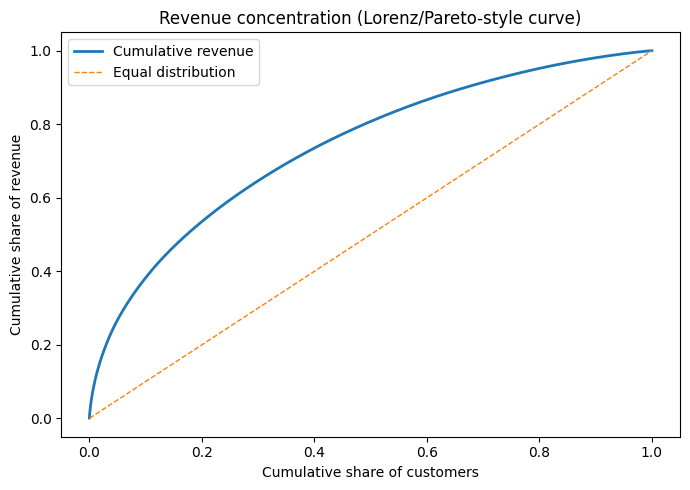

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(df["cum_customer_share"], df["cum_rev_share"], linewidth=2, label="Cumulative revenue")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Equal distribution")

plt.xlabel("Cumulative share of customers")
plt.ylabel("Cumulative share of revenue")
plt.title("Revenue concentration (Lorenz/Pareto-style curve)")
plt.legend()
plt.tight_layout()
plt.show()


Revenue concentration is significant but not extreme. The top 20% of customers generate
just over 53% of total revenue, while approximately 49% of customers are required to
reach 80% of revenue. The bottom third of the customer base contributes marginal value,
indicating inefficiencies in broad acquisition efforts.
